# Biotuner Toolbox Paper Results Figures

In [13]:
from biotuner.biotuner_object import *
from biotuner.metrics import *
import pandas as pd
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from neurodsp.sim import sim_combined
from scipy.interpolate import make_interp_spline, BSpline
from biotuner.biotuner_utils import generate_signal
from biotuner.biotuner_object import compute_biotuner
import numpy as np

### Figure 9. Performance analysis of different peak extraction methods

Processing method: fixed
Processing method: harmonic_recurrence
Processing method: EIMC
Processing method: EMD
Processing method: FOOOF


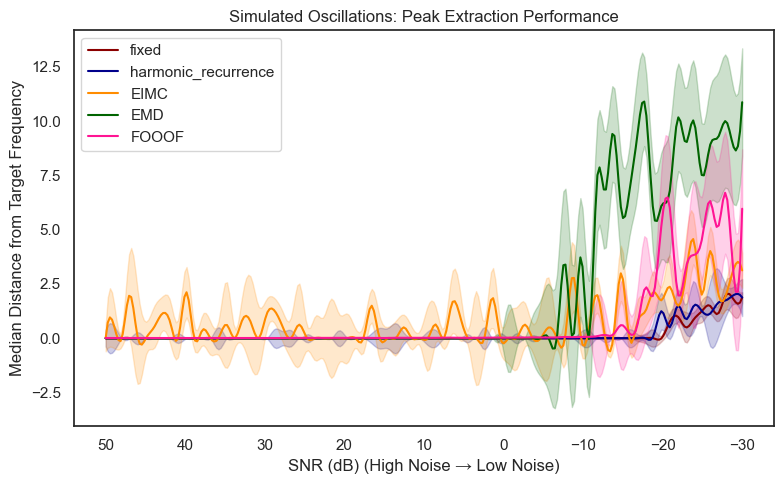

Processing method: fixed
Processing method: harmonic_recurrence
Processing method: EIMC
Processing method: EMD
Processing method: FOOOF


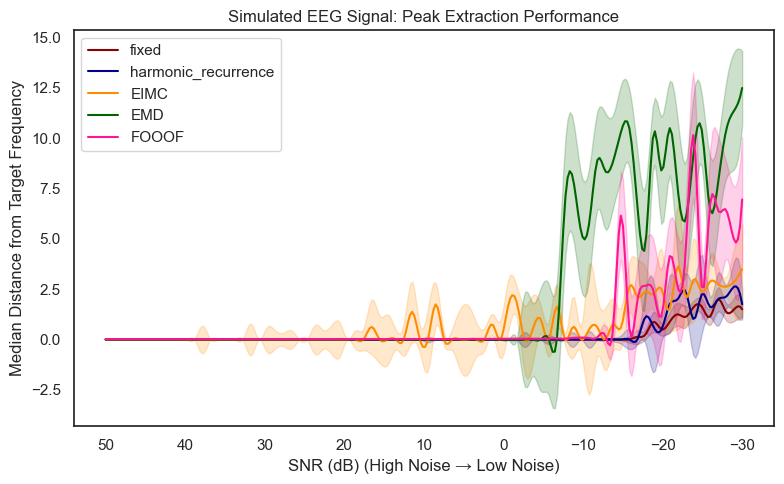

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
import warnings
warnings.filterwarnings("ignore")

# Setting up parameters
sf = 1000  # Sampling frequency
length = 4  # Signal duration in seconds
n_times = 10  # Number of bootstrap iterations
freqs = [2, 6, 12, 24]  # Target frequencies
amps = [1, 1, 1, 1]  # Amplitudes of target frequencies
FREQ_BANDS = [[1, 5], [5, 10], [10, 20], [20, 30]]  # Frequency bands
snr_db_list = np.linspace(-30, 50, 80)  # SNR levels in decibels, from low to high

# Simulate the combined signal
def sim_combined(length, sf, components, component_variances):
    t = np.arange(0, length, 1 / sf)
    signal = np.zeros_like(t)
    for comp, var in zip(components.values(), component_variances):
        if isinstance(comp, dict):  # Power-law component
            power_law_noise = np.random.normal(0, np.sqrt(var), len(t))
            signal += power_law_noise
        elif isinstance(comp, list):  # Oscillatory components
            for osc in comp:
                signal += var * np.sin(2 * np.pi * osc['freq'] * t)
    return signal

# Generate signals
components = {
    'sim_powerlaw': {'exponent': -1},
    'sim_oscillation': [{'freq': freq} for freq in freqs]
}
component_variances = [1 for _ in range(len(freqs) + 1)]  # Include power-law component
simulated_EEG = sim_combined(length, sf, components, component_variances)
simulated_oscillations = np.sum([amp * np.sin(2 * np.pi * freq * np.arange(0, length, 1 / sf)) 
                                  for freq, amp in zip(freqs, amps)], axis=0)
signals = {'Simulated Oscillations': simulated_oscillations, 'Simulated EEG Signal': simulated_EEG}

# Analyze signals across SNR levels
for title, signal in signals.items():
    peaks_methods = ['fixed', 'harmonic_recurrence', 'EIMC', 'EMD', 'FOOOF']
    colors = ['darkred', 'darkblue', 'darkorange', 'darkgreen', 'deeppink', 'deeppink']

    signal_power = np.mean(signal ** 2)  # Calculate signal power

    data = []
    for method, color in zip(peaks_methods, colors):
        print(f"Processing method: {method}")
        for snr_db in snr_db_list:
            t = 0
            median_distance = []
            while t < n_times:
                noise_power = signal_power / (10 ** (snr_db / 10))  # Calculate noise power for given SNR
                noise_signal = np.random.normal(0, np.sqrt(noise_power), len(signal))  # Generate noise
                noised_signal = signal + noise_signal

                # Parameters for Biotuner
                prominences = {'fixed': 10, 'harmonic_recurrence': 6, 'EMD': 1, 'FOOOF': 10, 'EIMC': 7}
                rel_heights = {'fixed': 1, 'harmonic_recurrence': 1, 'EMD': 0.7, 'FOOOF': 1, 'EIMC': 1}

                # Biotuner peak extraction
                biotuning = compute_biotuner(sf=sf, peaks_function=method, precision=0.5)
                biotuning.peaks_extraction(
                    noised_signal, min_freq=1, max_freq=50, min_harms=2, harm_limit=128, FREQ_BANDS=FREQ_BANDS,
                    verbose=False, graph=False, prominence=prominences[method], rel_height=rel_heights[method],
                    nIMFs=3, keep_first_IMF=True, n_peaks=4
                )

                if len(biotuning.peaks) == 0:
                    median_distance.append(np.nan)
                else:
                    list_distance = [
                        abs(p - min(freqs, key=lambda f: abs(f - p))) for p in biotuning.peaks
                    ]
                    median_distance.append(np.nanmedian(list_distance))
                t += 1

            data.append([method, snr_db, np.nanmedian(median_distance), np.nanstd(median_distance)])

    # Create DataFrame
    df = pd.DataFrame(data, columns=["Method", "SNR (dB)", "Median distance", "Std deviation"])

    # Plot results
    plt.figure(figsize=(8, 5))
    for method, color in zip(peaks_methods, colors):
        # Sort SNR in descending order to reverse the x-axis display
        df_method = df[df["Method"] == method].sort_values(by="SNR (dB)", ascending=False)
        x = df_method["SNR (dB)"]
        y = df_method["Median distance"]
        yerr = df_method["Std deviation"] / np.sqrt(n_times) * 1.96  # 95% CI

        # Reverse the order of x to ascending for interpolation
        x_interp = x[::-1]  # Reverse to make it increasing
        y_interp = y[::-1]  # Match order
        yerr_interp = yerr[::-1]  # Match order

        # Smooth line interpolation
        xnew = np.linspace(x_interp.min(), x_interp.max(), 300)
        spl = make_interp_spline(x_interp, y_interp, k=3)
        y_smooth = spl(xnew)
        spl_err = make_interp_spline(x_interp, yerr_interp, k=3)
        yerr_smooth = spl_err(xnew)

        plt.plot(xnew, y_smooth, label=method, color=color)
        plt.fill_between(xnew, y_smooth - yerr_smooth, y_smooth + yerr_smooth, color=color, alpha=0.2)

    # Adjust plot to reflect descending SNR
    plt.title(f"{title}: Peak Extraction Performance")
    plt.xlabel("SNR (dB) (High Noise → Low Noise)")
    plt.ylabel("Median Distance from Target Frequency")
    plt.legend()
    plt.tight_layout()
    plt.gca().invert_xaxis()  # Reverse the x-axis to show low SNR (high noise) on the right
    plt.show()





### Figure 10. Harmonicity on Simulated EEG

In [ ]:
import neurokit2 as nk
from biotuner.biotuner_object import compute_biotuner
from neurodsp.sim import sim_combined
import numpy as np
import matplotlib.pyplot as plt

# Parameters
sampling_rate = 1000
duration = 5
slopes = [-2, -1.75, -1.5, -1.25, -1, -0.75, -0.5, -0.25, -0.1]  # Varying levels of slope in the power law
n_bootstraps = 5
precision = 0.1

# Frequencies and amplitude
all_freqs = [[2, 6, 12, 24], [2.4, 5.8, 13, 23.1]]
FREQ_BANDS = [[1, 5], [5, 10], [10, 20], [20, 30]]

# Function to simulate EEG and compute harmonicity metrics
def simulate_and_compute_metrics(slope, sampling_rate, duration, freqs):
    components = {
        'sim_powerlaw': {'exponent': slope},
        'sim_oscillation': [{'freq': freq} for freq in freqs]
    }
    component_variances = [1 for _ in range(len(freqs) + 1)]
    
    # Simulate the EEG signal
    simulated_EEG = sim_combined(duration, sampling_rate, components=components, component_variances=component_variances)
    
    # Initialize BioTuning object
    biotuning = compute_biotuner(sf=sampling_rate, peaks_function='EMD', precision=precision)
    
    # Perform peak extraction
    biotuning.peaks_extraction(simulated_EEG, min_freq=1, max_freq=100, min_harms=2, harm_limit=128, 
                               verbose=False, graph=False, nIMFs=6, keep_first_IMF=False, n_peaks=6)
    
    # Select the first 4 peaks
    biotuning.peaks = biotuning.peaks[0:3]
    
    # Compute harmonicity metrics
    peaks = list(biotuning.peaks)
    peaks_ratios = compute_peak_ratios(peaks, rebound=True, octave=2, sub=False)
    

    # Compute metrics for the selected peaks
    _, _, _, cons = consonance_peaks(peaks, 0.001)
    if np.isnan(cons):
        print(peaks)
        print('Only octaves')
        cons = 2.0
    tenney = tenneyHeight(peaks)
    harmsim = np.nanmean(ratios2harmsim(peaks_ratios))
    _, _, subharm, _ = compute_subharmonic_tension(peaks, 5, 150, min_notes=2)
    subharm_tension = subharm[0] if isinstance(subharm[0], (int, float)) else 0.0  # Ensure numeric type
    peaks_euler = [int(round(num, 2) * 1000) for num in peaks]
    euler_ = euler(*peaks_euler)
    
    
    return {
        'consonance': cons,
        'tenney': tenney,
        'harmonic_similarity': harmsim,
        'subharmonic_tension': subharm_tension,
        'euler': euler_
    }


def compute_harmonicity(freqs):
    # Bootstrapping and collecting results
    results = {slope: {'consonance': [], 'tenney': [], 'harmonic_similarity': [], 'subharmonic_tension': [], 'euler': []} for slope in slopes}

    for slope in slopes:
        metrics_all = []
        for i in range(n_bootstraps):
            print(f'Slope: {slope}, Bootstrap iteration: {i}')
            metrics = simulate_and_compute_metrics(slope, sampling_rate, duration, freqs)
            metrics_all.append(metrics)

        # Summing metrics across all iterations
        summed_metrics = {
            'consonance': sum([metrics['consonance'] for metrics in metrics_all]),
            'tenney': sum([metrics['tenney'] for metrics in metrics_all]),
            'harmonic_similarity': sum([metrics['harmonic_similarity'] for metrics in metrics_all]),
            'subharmonic_tension': sum([metrics['subharmonic_tension'] for metrics in metrics_all]),
            'euler': sum([metrics['euler'] for metrics in metrics_all])
        }
        
        std_devs = {
            'consonance': np.std([metrics['consonance'] for metrics in metrics_all]),
            'tenney': np.std([metrics['tenney'] for metrics in metrics_all]),
            'harmonic_similarity': np.std([metrics['harmonic_similarity'] for metrics in metrics_all]),
            'subharmonic_tension': np.std([metrics['subharmonic_tension'] for metrics in metrics_all]),
            'euler': np.std([metrics['euler'] for metrics in metrics_all])
        }

        # Compute the average for each metric
        averaged_metrics = {key: value / n_bootstraps for key, value in summed_metrics.items()}
        std_devs = {key: value for key, value in std_devs.items()}
        # Store averaged metrics in the results dictionary
        results[slope]['consonance'] = [averaged_metrics['consonance']]
        results[slope]['tenney'] = [averaged_metrics['tenney']]
        results[slope]['harmonic_similarity'] = [averaged_metrics['harmonic_similarity']]
        results[slope]['subharmonic_tension'] = [averaged_metrics['subharmonic_tension']]
        results[slope]['euler'] = [averaged_metrics['euler']]
    return results, std_devs


results_low_harm, std_devs_low_harm = compute_harmonicity(all_freqs[1])
results_high_harm, std_devs_high_harm = compute_harmonicity(all_freqs[0])



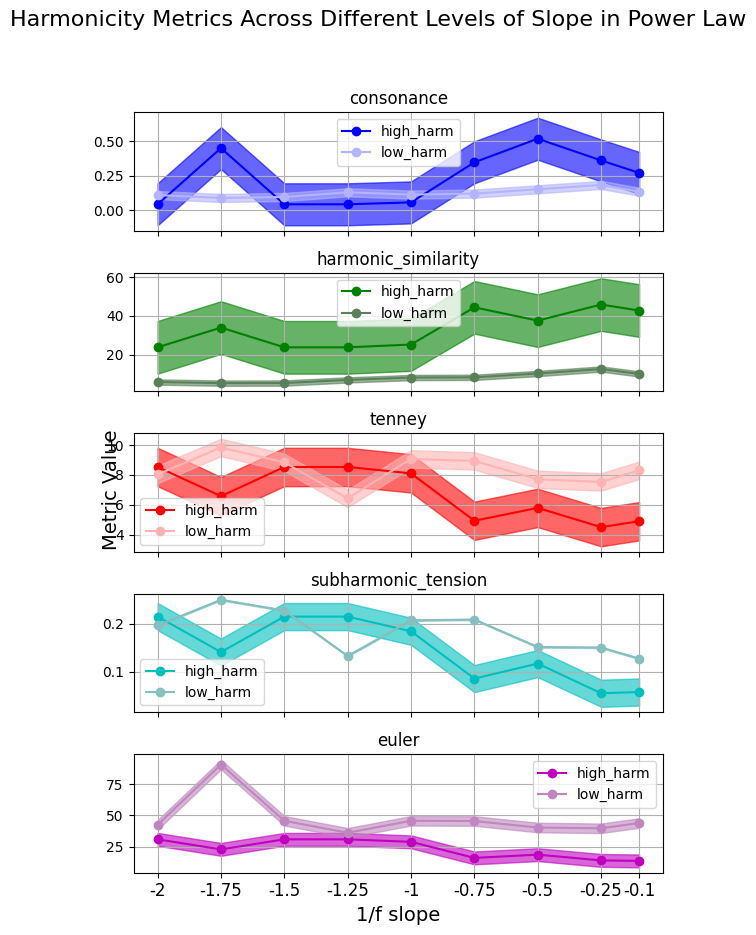

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
import colorsys

# Function to adjust the hue of a color
def adjust_hue(color, amount=0.1):
    rgb = mcolors.to_rgb(color)
    hsv = colorsys.rgb_to_hsv(*rgb)
    new_sat = (hsv[1] - amount)
    new_rgb = colorsys.hsv_to_rgb(hsv[0], new_sat, hsv[2])
    return new_rgb

base_colors = ['b', 'g', 'r', 'c', 'm']  # Original colors for each metric
labels = ['high_harm', 'low_harm']
metrics_labels = ['consonance', 'harmonic_similarity', 'tenney', 'subharmonic_tension', 'euler']

# Assuming results_low_harm, std_devs_low_harm, results_high_harm, std_devs_high_harm, slopes, and n_bootstraps are predefined
fig, axs = plt.subplots(len(metrics_labels), 1, figsize=(6, 2 * len(metrics_labels)), sharex=True)

for i, metric in enumerate(metrics_labels):
    for j, (results, std_devs) in enumerate(zip([results_high_harm, results_low_harm], [std_devs_high_harm, std_devs_low_harm])):
        # Extract and rescale the metric values between 0 and 1
        metric_values = [results[slope][metric][0] for slope in slopes]
        
        # Calculate the CI
        CI = 1.96 * np.array(std_devs[metric]) / np.sqrt(n_bootstraps)
        
        # Adjust color hue: slightly different hue for high_harm and low_harm
        color = base_colors[i]
        adjusted_color = adjust_hue(color, amount=0.7 * j)  # Adjust hue for the second line
        
        # Plotting the metric values with CI on the corresponding subplot
        axs[i].plot(slopes, metric_values, marker='o', color=adjusted_color, label=labels[j])
        axs[i].fill_between(slopes, np.array(metric_values) - CI, np.array(metric_values) + CI, color=adjusted_color, alpha=0.6)

    axs[i].set_title(metric)
    axs[i].grid(True)
    axs[i].legend()

# Customizing the shared x-axis and overall layout
fig.suptitle('Harmonicity Metrics Across Different Levels of Slope in Power Law', fontsize=16)
plt.xlabel('1/f slope', fontsize=14)
fig.text(0.04, 0.5, 'Metric Value', va='center', rotation='vertical', fontsize=14)
plt.xticks(slopes, [s for s in slopes], fontsize=12)

# Add a shared legend outside of the plot
#fig.legend(labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)

plt.tight_layout(rect=[0, 0.05, 1, 0.95])

plt.show()


### Figure 11a. Transitional Harmony in I-IV-V-I progression

c:\users\user\github\biotuner\biotuner\metrics.py:1016: RuntimeWarning: divide by zero encountered in scalar divide
  harm_temp.append(1/delta_norm)


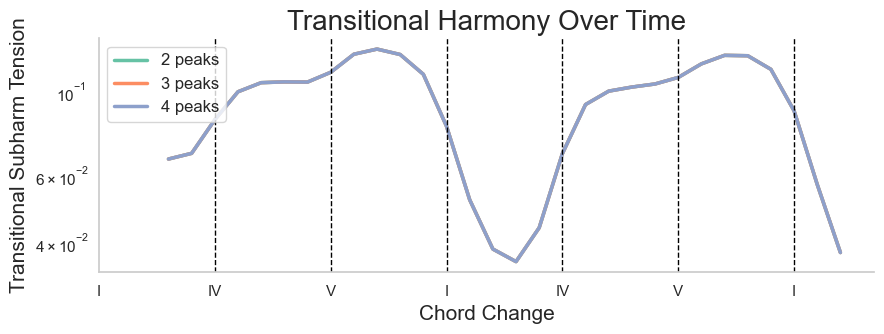

In [5]:
from biotuner.transitional_harmony import transitional_harmony
from biotuner.dictionaries import chord_frequencies
progressions = {
    'I-IV-V Progression': ['C', 'F', 'G', 'C', 'F', 'G', 'C']
}
precision=1
# Helper function to generate the signal for each chord progression
def generate_signal_for_progression(chord_sequence, chord_freqs, duration_per_chord=1, sampling_rate=10000):
    signal_length = duration_per_chord * len(chord_sequence) * sampling_rate
    time = np.linspace(0, duration_per_chord * len(chord_sequence), signal_length)
    signal = np.zeros_like(time)

    for i, chord in enumerate(chord_sequence):
        start = i * duration_per_chord * sampling_rate
        end = (i + 1) * duration_per_chord * sampling_rate
        for freq in chord_freqs[chord]:
            signal[start:end] += np.sin(2 * np.pi * freq * time[start:end])

    return signal, time

overlap=80
tharm=15
# Generate signals for each progression
sig_, time_ = generate_signal_for_progression(progressions['I-IV-V Progression'], chord_frequencies)

th = transitional_harmony(sf=10000, data=sig_, peaks_function='EMD', n_harm=10, precision=precision, n_trans_harm=tharm, max_freq=1000, max_harm_freq=20000,
                        FREQ_BANDS=None, n_peaks=2)
th_1, time_vec_final, subharm_melody = th.compute_trans_harmony(overlap=overlap, mode='win_overlap', delta_lim=5)

th2 = transitional_harmony(sf=10000, data=sig_, peaks_function='EMD', n_harm=10, precision=precision, n_trans_harm=tharm, max_freq=1000, max_harm_freq=20000,
                        FREQ_BANDS=None, n_peaks=3)
th2_1, time_vec_final, subharm_melody = th2.compute_trans_harmony(overlap=overlap, mode='win_overlap', delta_lim=5)

th3 = transitional_harmony(sf=10000, data=sig_, peaks_function='EMD', n_harm=10, precision=precision, n_trans_harm=tharm, max_freq=1000, max_harm_freq=20000,
                        FREQ_BANDS=None, n_peaks=4)

th3_1, time_vec_final, subharm_melody = th3.compute_trans_harmony(overlap=overlap, mode='win_overlap', delta_lim=5)

from scipy.ndimage import gaussian_filter1d

# Set the Seaborn style
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(9, 3.5))

# Generate two separate color palettes for H10 and H5
colors_h10 = sns.color_palette("Set2", n_colors=3)  # Degradé for H10
colors_h5 = sns.color_palette("Oranges_r", n_colors=5)  # Degradé for H5

# Plot the transitional harmony vectors for H15
for i, trans_subharm in enumerate([th_1, th2_1, th3_1]):
    sigma = 1.  # Smoothing parameter
    y_smooth = gaussian_filter1d(trans_subharm, sigma=sigma)
    plt.plot(time_vec_final, y_smooth, linewidth=2.5, color=colors_h10[i], label=f'{i+2} peaks')


# Customization of the plot
plt.xlabel('Chord Change', fontsize=15)
plt.ylabel('Transitional Subharm Tension', fontsize=15)
plt.title('Transitional Harmony Over Time', fontsize=20)
plt.xticks([0, 1, 2, 3, 4, 5, 6], ['I', 'IV', 'V', 'I', 'IV', 'V', 'I'])

plt.legend(loc='upper left', fontsize=12)

# add vertical dashed black lines for chord changes
for i in range(1, 7):
    chord_change_time = i * 1
    plt.axvline(x=chord_change_time, color='black', linestyle='--', linewidth=1)
# log y-scale
plt.yscale('log')
sns.despine()  # Remove top and right borders
sns.set(font_scale=1)  # Set font scale
plt.grid(False)  # Remove grid
plt.tight_layout()  # Ensure everything fits without overlapping

# Save and show the figure
#plt.savefig('transitional_harmony_I_IV_V_I.png', dpi=300)
plt.show()

### Figure 11b. Smoothed transitional harmony for ecg simulated signals

c:\users\user\github\biotuner\biotuner\metrics.py:1016: RuntimeWarning: divide by zero encountered in scalar divide
  harm_temp.append(1/delta_norm)
C:\Users\User\AppData\Local\Temp\ipykernel_7540\926778720.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Dark2_r')


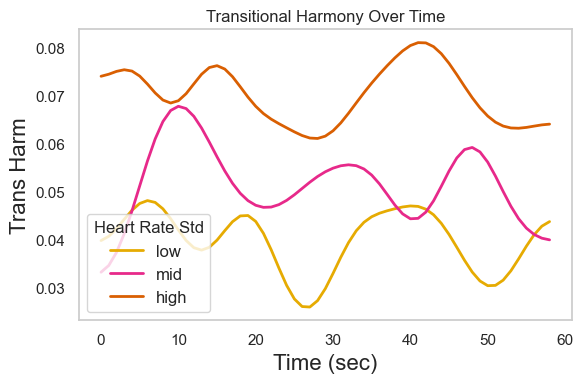

In [6]:
import neurokit2 as nk
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import seaborn as sns
from biotuner.transitional_harmony import transitional_harmony

# Parameters
sampling_rate = 1000
duration = 60
heart_rate = 120
noise = 0.1
std_values = [1, 15, 30]  # Heart rate standard deviations
precision = 1

# Function to simulate ECG and apply transitional harmony
def simulate_and_compute_th(std):
    ecg = nk.ecg_simulate(duration=duration, sampling_rate=sampling_rate, heart_rate=heart_rate, heart_rate_std=std, noise=noise)
    th = transitional_harmony(sf=sampling_rate, data=ecg, peaks_function='EMD', n_harm=10, precision=precision, n_trans_harm=5, 
                              min_freq=0.1, max_freq=50, max_harm_freq=2000, FREQ_BANDS=None, n_peaks=2)
    trans_subharm, _, _ = th.compute_trans_harmony(overlap=0.7, mode='win_overlap', delta_lim=100, keep_first_IMF=False)
    return trans_subharm, ecg

# Simulate ECG data and compute transitional harmony for each standard deviation
transitional_harmonies = []
ecgs = []
for std in std_values:
    ts, ecg = simulate_and_compute_th(std)
    transitional_harmonies.append(ts)
    ecgs.append(ecg)
    

# Plotting
plt.figure(figsize=(6, 4))
sns.set(style="whitegrid")
# Updated lines to select colors 2, 4, and 6 from Set2_r colormap
total_colors_in_set2_r = 8
color_indices = np.array([2, 4, 6]) / total_colors_in_set2_r
cmap = plt.cm.get_cmap('Dark2_r')
labels = ['low', 'mid', 'high']
# Use the updated color_indices in the plotting loop
for th, label, color in zip(transitional_harmonies, labels, cmap(color_indices)):
    th_filtered = gaussian_filter1d(th, sigma=4)
    plt.plot(th_filtered, label=label, linewidth=2, color=color)

# Customize plot
plt.legend(loc='lower left', fontsize=12, title='Heart Rate Std', title_fontsize=12)
plt.title("Transitional Harmony Over Time")
plt.xlabel("Time (sec)", fontsize=16)
plt.ylabel("Trans Harm", fontsize=16)
plt.grid(False)
plt.tight_layout()
#plt.savefig('trans_harm_heartrate_IF.png', dpi=300)
plt.show()

### Figure 11c. Distribution of transitional harmony values

C:\Users\User\AppData\Local\Temp\ipykernel_7540\1609221077.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Heart Rate Std', y='Average Transitional Harmony', data=df_avg, palette='pastel')


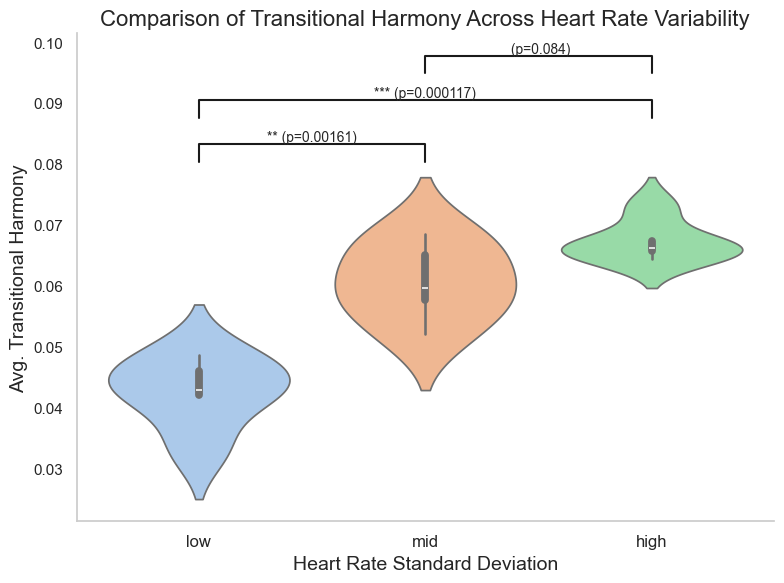

In [7]:
import neurokit2 as nk
from biotuner.transitional_harmony import transitional_harmony
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Parameters
sampling_rate = 1000
duration = 60
heart_rate = 120
noise = 0.1
n_bootstraps = 5

# Standard deviations for heart rate
std_values = [1, 15, 30]

# Function to simulate ECG and compute transitional harmony
def simulate_and_compute_th(std, sampling_rate, duration, heart_rate, noise):
    ecg = nk.ecg_simulate(duration=duration, sampling_rate=sampling_rate, heart_rate=heart_rate, heart_rate_std=std, noise=noise)
    th = transitional_harmony(sf=sampling_rate, data=ecg, peaks_function='EMD', n_harm=10, precision=1, n_trans_harm=5, 
                              min_freq=0.1, max_freq=50, max_harm_freq=2000, FREQ_BANDS=None, n_peaks=2)
    trans_subharm, _, _ = th.compute_trans_harmony(overlap=0.7, mode='win_overlap', delta_lim=100, keep_first_IMF=False)
    return trans_subharm

# Bootstrapping
results = {std: [] for std in std_values}

for std in std_values:
    for _ in range(n_bootstraps):
        trans_subharm = simulate_and_compute_th(std, sampling_rate, duration, heart_rate, noise)
        results[std].append(trans_subharm)

# Prepare data for DataFrame
averaged_data = []
for std, list_of_values in results.items():
    for values in list_of_values:
        avg_value = np.mean(values)  # Calculate average of each list
        averaged_data.append({'Heart Rate Std': std, 'Average Transitional Harmony': avg_value})

# Create DataFrame
df_avg = pd.DataFrame(averaged_data)

# Perform t-tests between all pairs
t_test_results = []
pairs = [(std_values[i], std_values[j]) for i in range(len(std_values)) for j in range(i + 1, len(std_values))]

for std1, std2 in pairs:
    group1 = [np.mean(x) for x in results[std1]]
    group2 = [np.mean(x) for x in results[std2]]
    t_stat, p_val = ttest_ind(group1, group2, equal_var=False)
    t_test_results.append({'Pair': f'{std1} vs {std2}', 'p-value': p_val})

# Annotate the violin plot
plt.figure(figsize=(8, 6))
#sns.set_style("whitegrid")
sns.violinplot(x='Heart Rate Std', y='Average Transitional Harmony', data=df_avg, palette='pastel')

# Add annotations dynamically
max_y = df_avg['Average Transitional Harmony'].max()
y_offset = max_y * 0.1
bracket_height = y_offset * 0.4
for (std1, std2), t_res in zip(pairs, t_test_results):
    p_val = t_res['p-value']
    significance = ''
    if p_val < 0.001:
        significance = '***'
    elif p_val < 0.01:
        significance = '**'
    elif p_val < 0.05:
        significance = '*'
    
    x1, x2 = std_values.index(std1), std_values.index(std2)
    y = max_y + y_offset
    plt.plot([x1, x1, x2, x2], [y, y + bracket_height, y + bracket_height, y], lw=1.5, color='k')
    plt.text((x1 + x2) * 0.5, y + bracket_height, f'{significance} (p={p_val:.3g})', ha='center', va='bottom', fontsize=10)
    max_y += y_offset  # Increment y for next annotation

# Customizing plot
plt.xlabel('Heart Rate Standard Deviation', fontsize=14)
plt.ylabel('Avg. Transitional Harmony', fontsize=14)
plt.xticks(range(len(std_values)), ['low', 'mid', 'high'], fontsize=12)
plt.title('Comparison of Transitional Harmony Across Heart Rate Variability', fontsize=16)
plt.grid(False)
sns.despine()

plt.tight_layout()
plt.show()


### Figure 12. Transitional harmony on simulated EEG

In [ ]:
import neurokit2 as nk
from biotuner.transitional_harmony import transitional_harmony
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from neurodsp.sim import sim_combined

# Parameters
sampling_rate = 1000
duration = 60
n_bootstraps = 5  # Number of bootstraps
slope = -1  # Power law slope

# Peaks for EEG simulation
peaks_sets = {
    'Set 1': [2, 6, 12, 24],
    'Set 2': [2.4, 5.8, 13, 23.1]
}

# Function to simulate EEG and compute transitional harmony
def simulate_and_compute_th(peaks, sampling_rate, duration, slope):
    # Define components for sim_combined
    components = {
        'sim_powerlaw': {'exponent': slope},
        'sim_oscillation': [{'freq': freq} for freq in peaks]
    }
    
    # Simulate the EEG signal
    simulated_EEG = sim_combined(duration, sampling_rate, components=components)
    
    # Compute transitional harmony
    th = transitional_harmony(sf=sampling_rate, data=simulated_EEG, peaks_function='EMD', n_harm=10, precision=0.5, n_trans_harm=5, 
                              min_freq=1, max_freq=50, max_harm_freq=2000, FREQ_BANDS=None, n_peaks=3)
    trans_subharm, _, _ = th.compute_trans_harmony(overlap=0.7, mode='win_overlap', delta_lim=150, keep_first_IMF=False)
    
    return trans_subharm

# Bootstrapping
results = {label: [] for label in peaks_sets.keys()}

for label, peaks in peaks_sets.items():
    for _ in range(n_bootstraps):
        trans_subharm = simulate_and_compute_th(peaks, sampling_rate, duration, slope)
        results[label].append(np.mean(trans_subharm))  # Store the mean of the transitional harmony values

# Prepare data for DataFrame
averaged_data = []
for label, values in results.items():
    for avg_value in values:
        averaged_data.append({'Peaks Set': label, 'Average Transitional Harmony': avg_value})

# Create DataFrame
df_avg = pd.DataFrame(averaged_data)




-4.428224258896778 0.002202212687854339


C:\Users\User\AppData\Local\Temp\ipykernel_7540\2376681667.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Peaks Set', y='Average Transitional Harmony', data=df_avg, palette='Set2')


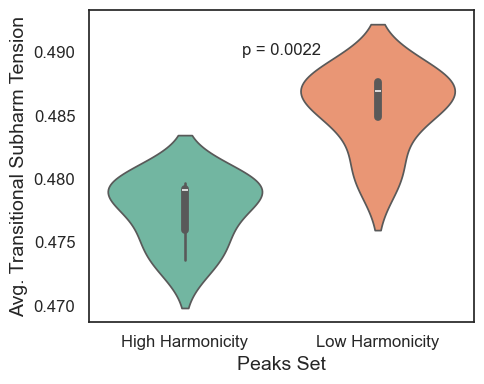

In [9]:
import scipy.stats as stats

# Replace 'Set 1' by High Harmonicity and 'Set 2' by Low Harmonicity
df_avg['Peaks Set'] = df_avg['Peaks Set'].replace({'Set 1': 'High Harmonicity', 'Set 2': 'Low Harmonicity'})

# Perform an independent t-test
high_harm = df_avg[df_avg['Peaks Set'] == 'High Harmonicity']['Average Transitional Harmony']
low_harm = df_avg[df_avg['Peaks Set'] == 'Low Harmonicity']['Average Transitional Harmony']
t_stat, p_value = stats.ttest_ind(high_harm, low_harm)
print(t_stat, p_value)


# Create the violin plot with averaged values
plt.figure(figsize=(5, 4))
sns.set_style("white")
sns.violinplot(x='Peaks Set', y='Average Transitional Harmony', data=df_avg, palette='Set2')

# Add the p-value to the plot
if p_value < 0.001:
    plt.text(0.5, max(df_avg['Average Transitional Harmony']) + 0.002, 'p < 0.001', ha='center', fontsize=12)
else:
    plt.text(0.5, max(df_avg['Average Transitional Harmony']) + 0.002, f'p = {p_value:.4f}', ha='center', fontsize=12)

# Customizing plot
plt.xlabel('Peaks Set', fontsize=14)
plt.ylabel('Avg. Transitional Subharm Tension', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()


### Figure 13. Harmonic Connectivity

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from neurodsp.sim import sim_combined
from biotuner.harmonic_connectivity import harmonic_connectivity
import pandas as pd

# Parameters
sampling_rate = 1000
duration = 10  # in seconds
slope = -1
n_bootstraps = 5  # Number of bootstraps for variability estimation

# Frequencies for harmonic and non-harmonic sets
harm_freqs = [10, 20, 30]
nonharm_freqs = [9.6, 22.3, 29.5]

nonharm_freqs = [2.4, 5.8, 13, 23.1]
harm_freqs = [2, 6, 12, 24]

# Function to generate EEG signals
def generate_eeg_signal(freqs, duration, sampling_rate, slope):
    components = {
        'sim_powerlaw': {'exponent': slope},
        'sim_oscillation': [{'freq': freq} for freq in freqs]
    }
    component_variances = [1 for _ in range(len(freqs) + 1)]
    simulated_EEG = sim_combined(duration, sampling_rate, components=components, component_variances=component_variances)
    return simulated_EEG

# Frequency bands (example)
FREQ_BANDS = [[15, 26], [26, 36], [36, 46]]

# List to store bootstrapped results
bootstrapped_results = []

# Bootstrapping loop
for _ in range(n_bootstraps):
    # Generate signals
    eeg_harm1 = generate_eeg_signal(harm_freqs, duration, sampling_rate, slope)
    eeg_harm2 = generate_eeg_signal(harm_freqs, duration, sampling_rate, slope)
    eeg_nonharm = generate_eeg_signal(nonharm_freqs, duration, sampling_rate, slope)
    
    # Create pairs of signals
    signals_harm_harm = np.array([eeg_harm1, eeg_harm2])
    signals_harm_nonharm = np.array([eeg_harm1, eeg_nonharm])

    # Compute connectivity for each metric
    metrics = ['harmsim', 'subharm_tension', 'wPLI_crossfreq', 'RRCi']
    for metric in metrics:
        hc_harm_harm = harmonic_connectivity(sf=sampling_rate, data=signals_harm_harm, min_freq=1, max_freq=50, precision=0.1, peaks_function='EMD', n_harm=10, n_peaks=4)
        result_harm_harm = hc_harm_harm.compute_harm_connectivity(metric=metric, FREQ_BANDS=FREQ_BANDS, graph=False)
        
        hc_harm_nonharm = harmonic_connectivity(sf=sampling_rate, data=signals_harm_nonharm, min_freq=1, max_freq=50, precision=0.1, peaks_function='EMD', n_harm=10, n_peaks=4)
        result_harm_nonharm = hc_harm_nonharm.compute_harm_connectivity(metric=metric, FREQ_BANDS=FREQ_BANDS, graph=False)
        
        # Store the average results for the off-diagonal elements of the matrix
        harm_harm_value = np.nanmean(result_harm_harm[np.triu_indices_from(result_harm_harm, k=1)])
        harm_nonharm_value = np.nanmean(result_harm_nonharm[np.triu_indices_from(result_harm_nonharm, k=1)])

        bootstrapped_results.append({'Metric': metric, 'Pair Type': 'Harm-Harm', 'Value': harm_harm_value})
        bootstrapped_results.append({'Metric': metric, 'Pair Type': 'Harm-Nonharm', 'Value': harm_nonharm_value})


# Convert bootstrapped results to DataFrame
df = pd.DataFrame(bootstrapped_results)




c:\Users\User\anaconda3\envs\biotuner_test\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\User\AppData\Local\Temp\ipykernel_7540\3175379112.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_metric['Pair Type'] = data_metric['Pair Type'].replace({'Harm-Harm': 'H-H', 'Harm-Nonharm': 'H-NH'})
C:\Users\User\AppData\Local\Temp\ipykernel_7540\3175379112.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False`

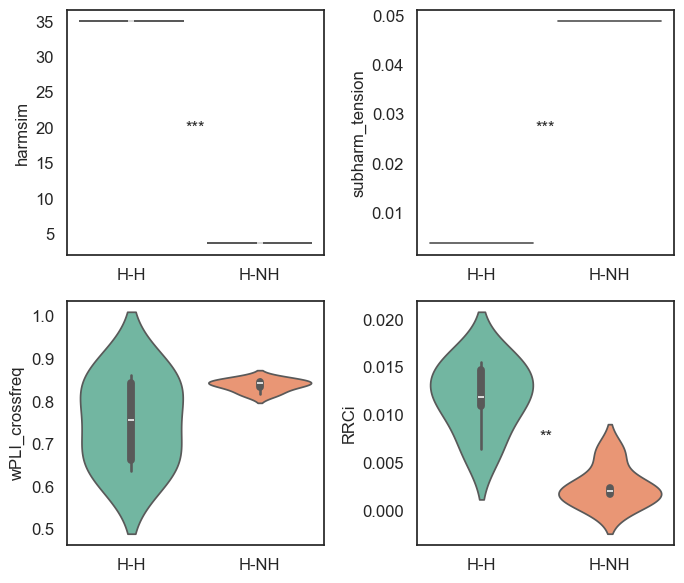

In [12]:
import scipy.stats as stats
plt.figure(figsize=(7, 6))

for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)
    
    # Subset data for the current metric
    data_metric = df[df['Metric'] == metric]
    
    # Perform t-test
    harm_harm_values = data_metric[data_metric['Pair Type'] == 'Harm-Harm']['Value']
    harm_nonharm_values = data_metric[data_metric['Pair Type'] == 'Harm-Nonharm']['Value']
    t_stat, p_value = stats.ttest_ind(harm_harm_values, harm_nonharm_values)
    
    # change Harm-Harm for H-H and Harm-Nonharm for H-NH
    data_metric['Pair Type'] = data_metric['Pair Type'].replace({'Harm-Harm': 'H-H', 'Harm-Nonharm': 'H-NH'})
    
    # Create violin plot
    sns.violinplot(x='Pair Type', y='Value', data=data_metric, palette='Set2')
    
    # Add p-value to the plot
    if p_value < 0.001:
        plt.text(0.5, np.mean(data_metric['Value']), '***', ha='center', fontsize=12)
    elif p_value < 0.01:
        plt.text(0.5, np.mean(data_metric['Value']), '**', ha='center', fontsize=12)
    elif p_value < 0.05:
        plt.text(0.5, np.mean(data_metric['Value']), '*', ha='center', fontsize=12)
    
    # Customize the plot
    plt.xlabel('')
    plt.ylabel(metric, fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

plt.tight_layout()
# save the plot in 300 dpi
plt.savefig('connectivity_metrics.png', dpi=300)
plt.show()